# Pole Balancing - Tabular method

### Jeong Ji Hoon 2021

# 1. Import Packages

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

# 2. Random simulation to obtain state distribution

In [2]:
state_bucket = np.zeros((0, 4))

env = gym.make('CartPole-v0')
for i in np.arange(100):
    state = env.reset()
    finish = False
    state_bucket = np.vstack((state_bucket, state))
    while not finish:
        state, reward, finish, _ = env.step(env.action_space.sample())
        state_bucket = np.vstack((state_bucket, state))

Text(0.5, 0.98, 'State distribution')

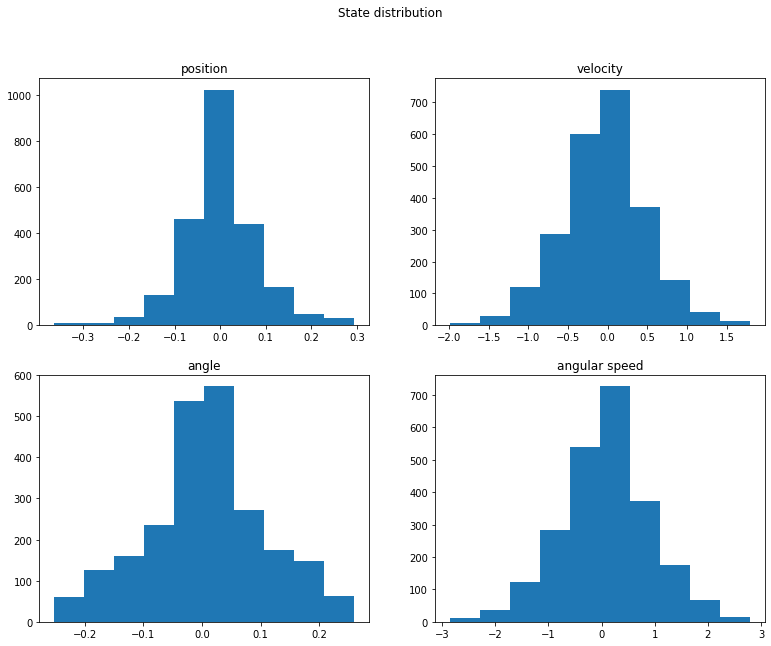

In [3]:
fig = plt.figure(figsize=(13,10))
ax = fig.subplots(2,2)
ax[0,0].hist(state_bucket[:,0])
ax[0,0].set_title('position')
ax[0,1].hist(state_bucket[:,1])
ax[0,1].set_title('velocity')
ax[1,0].hist(state_bucket[:,2])
ax[1,0].set_title('angle')
ax[1,1].hist(state_bucket[:,3])
ax[1,1].set_title('angular speed')
fig.suptitle('State distribution')

# 3. Binning

In [4]:
Number_of_bin = 8
bucket_size = state_bucket.shape[0]
binning_criterion = np.zeros((Number_of_bin-1,4))
cutting_index = np.round(np.linspace(0,bucket_size-1,Number_of_bin-1)).astype(np.int)
# for each dimension
for dim in np.arange(4):
    sorted = np.sort(state_bucket[:,dim]) # sort all observed states in ascending order
    binning_criterion[:,dim] = sorted[cutting_index] # cut them with the same spacing

Text(0.5, 1.0, 'angular speed')

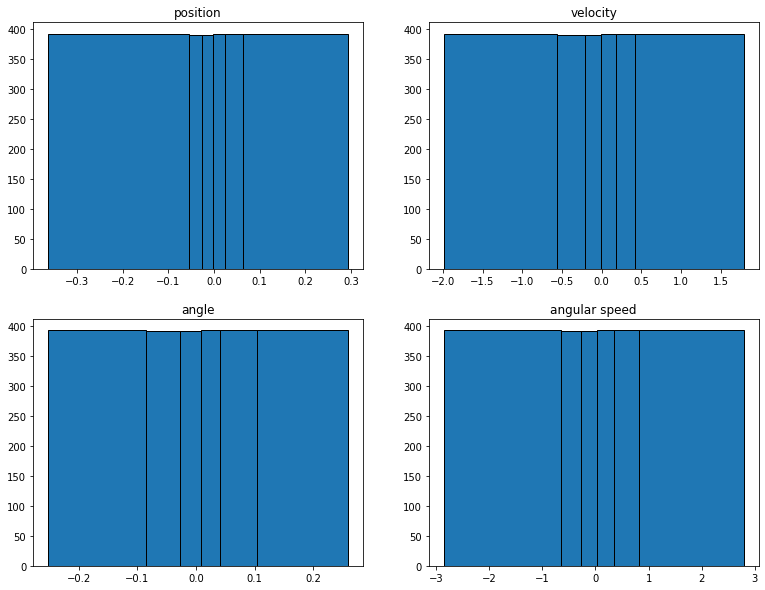

In [5]:
fig = plt.figure(figsize=(13,10))
ax = fig.subplots(2,2)
ax[0,0].hist(state_bucket[:,0],binning_criterion[:,0], ec='k')
ax[0,0].set_title('position')
ax[0,1].hist(state_bucket[:,1],binning_criterion[:,1], ec='k')
ax[0,1].set_title('velocity')
ax[1,0].hist(state_bucket[:,2],binning_criterion[:,2], ec='k')
ax[1,0].set_title('angle')
ax[1,1].hist(state_bucket[:,3],binning_criterion[:,3], ec='k')
ax[1,1].set_title('angular speed')

* black lines indicate binning criterion.
* dense in the middle and sparse in extremities

## Q table function

In [7]:
def getQtableIndex(state):
    result = np.zeros((4,),dtype=int)
    for dim in np.arange(4):
        result[dim] = len(np.where(binning_criterion[:,dim]<state[dim])[0]) #using the binning_criterion, decide the table index of the given state
    return result

# 4. Learning

## parameters

In [47]:
Number_of_episodes = 2000
learning_rate = np.linspace(0.1, 0.01, Number_of_episodes) # slightly decreasing learning rate
e = np.linspace(0.3,0,Number_of_episodes) # slightly decreasing exploration rate
gamma = 0.9

## value function

In [48]:
# 5D matrix (binned position x binned horizontal speed x binned angle x binned angular speed x action)
value_function = 1 * np.ones((Number_of_bin, Number_of_bin, Number_of_bin, Number_of_bin,2)) 

## Learning

In [49]:
totaltime = time.time()
score = np.zeros(Number_of_episodes)

# For each episodes
for epoch in np.arange(Number_of_episodes): 
    epochtime = time.time()
    state = env.reset()
    finish = False
    table_index = getQtableIndex(state)
    # Run until the simulation finishs
    while not finish:
        current_values = value_function[table_index[0], table_index[1], table_index[2], table_index[3], :]
        
        # Go Random?
        if np.random.rand(1) < e[epoch]:  # go random
            currAction = np.random.choice(np.array([0, 1], dtype=int))
        else:  # select the best action
            best_action = np.argmax(current_values)
            if np.sum(current_values == current_values[best_action]) > 1:  # if there are multiple best actions,
                best_action = np.random.choice(np.array([0, 1], dtype=int))  # randomly choose one
            currAction = best_action
        
        # Do action
        new_state, reward, finish, _ = env.step(currAction)
        
        # Calculate Reward
        if finish and score[epoch] < env._max_episode_steps: # pole fallen
            reward = -1000
        else:
            reward = 1     
            
        # Update Value
        new_table_index = getQtableIndex(new_state)
        value_function[table_index[0], table_index[1], table_index[2], table_index[3], currAction] += \
            learning_rate[epoch] * ((reward + gamma * np.max(value_function[new_table_index[0], new_table_index[1], new_table_index[2], new_table_index[3], :])) - current_values[currAction])
        
        # Move to the next Trial
        score[epoch] += 1
        table_index = new_table_index
        state = new_state
    if epoch % 100 == 0:
        print('Epoch : {:04d} : {:.5f} sec | number of moves : {:03d}'.format(epoch, time.time() - epochtime, score[epoch].astype(int)))
        print("====================================================")
print("Total Time : " + str(time.time() - totaltime) + "sec")

Epoch : 0000 : 0.00248 sec | number of moves : 014
Epoch : 0100 : 0.00322 sec | number of moves : 079
Epoch : 0200 : 0.00128 sec | number of moves : 030
Epoch : 0300 : 0.00158 sec | number of moves : 025
Epoch : 0400 : 0.00638 sec | number of moves : 103
Epoch : 0500 : 0.00740 sec | number of moves : 177
Epoch : 0600 : 0.00205 sec | number of moves : 046
Epoch : 0700 : 0.00725 sec | number of moves : 175
Epoch : 0800 : 0.00434 sec | number of moves : 085
Epoch : 0900 : 0.00787 sec | number of moves : 189
Epoch : 1000 : 0.00195 sec | number of moves : 048
Epoch : 1100 : 0.00807 sec | number of moves : 189
Epoch : 1200 : 0.00850 sec | number of moves : 200
Epoch : 1300 : 0.00830 sec | number of moves : 200
Epoch : 1400 : 0.00733 sec | number of moves : 175
Epoch : 1500 : 0.00828 sec | number of moves : 200
Epoch : 1600 : 0.00849 sec | number of moves : 200
Epoch : 1700 : 0.01302 sec | number of moves : 200
Epoch : 1800 : 0.00873 sec | number of moves : 200
Epoch : 1900 : 0.00531 sec | nu

Text(0.5, 1.0, 'Score')

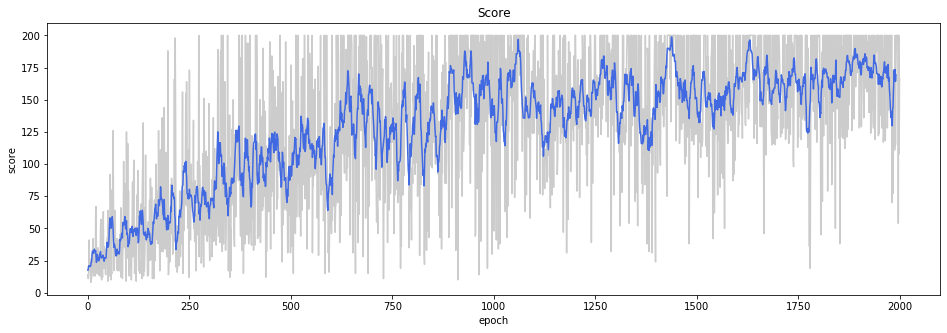

In [50]:
fig = plt.figure(figsize=(16,5))
ax = fig.subplots(1,1)
ax.plot(score,color='k',alpha=0.2)
ax.plot(np.convolve(score, np.ones(10),'valid')/10, color='royalblue') # 5 window moving avg. 
ax.set_xlabel('epoch')
ax.set_ylabel('score')
ax.set_title('Score')

## Test

In [54]:
test_score = 0
state = env.reset()
finish = False
table_index = getQtableIndex(state)
# Run until the simulation finishs
while not finish:
    current_values = value_function[table_index[0], table_index[1], table_index[2], table_index[3], :]

    best_action = np.argmax(current_values)
    if np.sum(current_values == current_values[best_action]) > 1:  # if there are multiple best actions,
        best_action = np.random.choice(np.array([0, 1], dtype=int))  # randomly choose one
    currAction = best_action

    # Do action
    new_state, reward, finish, _ = env.step(currAction)
    env.render()
    time.sleep(0.1)

    # Move to the next Trial
    test_score += 1
    table_index = getQtableIndex(new_state)
    state = new_state
env.close()
print(test_score)

200
